<a href="https://colab.research.google.com/github/ayush2991/imdb-reviews/blob/main/imdb_dnn_one_hot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
import numpy as np
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

In [75]:
# imdb.load_data?
# Using this help command, we learn that:
# 1. The function call returns (x_train, y_train), (x_test, y_test)
# 2. words are indexed by frequency, so 1 = most common token
# 3. 0 is the placeholder for unknown tokens
# 4. index_from=3 so indices 0, 1, 2 are reserved for special tokens.

In [76]:
VOCAB_SIZE = 10000

In [77]:
word_index = imdb.get_word_index()
print("# unqiue tokens = ", len(word_index.items()))

# unqiue tokens =  88584


In [78]:
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = imdb.load_data(num_words=VOCAB_SIZE)
# num_words = 10,000 is perhaps an arbitray choice but seems like 
# a good starting point because it is unlikely that people need more 
# than 10,000 real english words to express their views about a movie.
# This choice is also informed by my prior work on large NLP systems
# which required no more than 50,000 tokens for complete expression.
# We can always tune this hyperparameter, if need be.

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [79]:
# Let's see what the data looks like
print(x_train_raw[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [80]:
# and, in human-readable form
reverse_index = {v:k for (k, v) in word_index.items()}
words = [reverse_index.get(token-3 , '?') for token in x_train_raw[0]]
review = ' '.join(words)
print(review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [81]:
# texts: A list of N reviews, where each review is a sequence of tokens of 
# variable length. For example, texts = [[3, 1, 8, ..], [9, 3, ..], ...]
# vocab_size: The size of one-hot vector to which we'll map each review text.
# Returns X, a matrix of shape (N, vocab_size)
def to_one_hot(texts, vocab_size):
  X = np.zeros((len(texts), vocab_size))
  for i, indices in enumerate(texts):
    X[i, indices] = 1
  return X

In [82]:
# Encode all reviews into one-hot vectors which we can feed into DNNs.
x_train = to_one_hot(x_train_raw, VOCAB_SIZE)
x_test = to_one_hot(x_test_raw, VOCAB_SIZE)

num_train_examples = len(y_train_raw)
num_test_examples = len(y_test_raw)

assert x_train.shape == (num_train_examples, VOCAB_SIZE)
assert x_test.shape == (num_test_examples, VOCAB_SIZE)

print(x_train.shape)
print(x_test.shape)

(25000, 10000)
(25000, 10000)


In [83]:
# Cast labels from list type to a numpy array.
y_train = np.asarray(y_train_raw).astype('float32')
y_test = np.asarray(y_test_raw).astype('float32')

assert y_train.shape == (num_train_examples, )
assert y_test.shape == (num_test_examples, )

print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)


In [84]:
# A naive DNN with the following architecture. 
# X -> hidden layer 1 -> hidden layer 2 -> output layer
model = models.Sequential([
  layers.Dense(units=16, activation='relu', input_shape=(VOCAB_SIZE, )),
  layers.Dense(units=16, activation='relu'),
  layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [85]:
# How do we measure loss, optimize it and measure performance on holdout data?
# Adam stands for adaptive moment estimation and is almost always a good first 
# pick, along with RMSProp.
model.compile(loss=losses.binary_crossentropy, 
              optimizer=optimizers.RMSprop(), 
              metrics=[metrics.binary_accuracy])

In [86]:
# Perform the actual training.
history = model.fit(x=x_train, y=y_train, batch_size=512, epochs=10, 
                    validation_split=0.2, shuffle=True)

Epoch 1/10
40/40 [==============================] - 2s 45ms/step - loss: 0.5909 - binary_accuracy: 0.7073 - val_loss: 0.3813 - val_binary_accuracy: 0.8796
Epoch 2/10
40/40 [==============================] - 1s 31ms/step - loss: 0.3197 - binary_accuracy: 0.9041 - val_loss: 0.2945 - val_binary_accuracy: 0.8936
Epoch 3/10
40/40 [==============================] - 1s 31ms/step - loss: 0.2259 - binary_accuracy: 0.9280 - val_loss: 0.2847 - val_binary_accuracy: 0.8902
Epoch 4/10
40/40 [==============================] - 1s 31ms/step - loss: 0.1761 - binary_accuracy: 0.9443 - val_loss: 0.2788 - val_binary_accuracy: 0.8932
Epoch 5/10
40/40 [==============================] - 1s 31ms/step - loss: 0.1435 - binary_accuracy: 0.9550 - val_loss: 0.2889 - val_binary_accuracy: 0.8898
Epoch 6/10
40/40 [==============================] - 1s 32ms/step - loss: 0.1181 - binary_accuracy: 0.9646 - val_loss: 0.3106 - val_binary_accuracy: 0.8894
Epoch 7/10
40/40 [==============================] - 1s 31ms/step - los

In [87]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

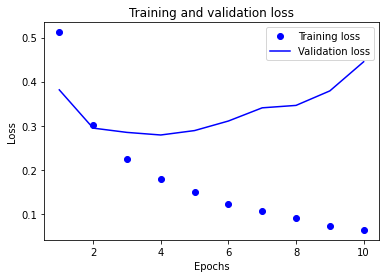

In [88]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

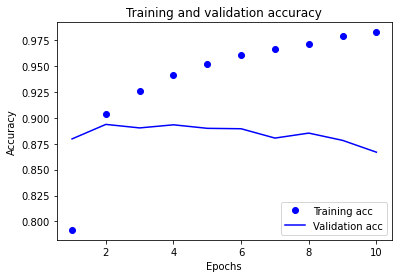

In [89]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [90]:
model.evaluate(x=x_test, y=y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.4566 - binary_accuracy: 0.8560


[0.4565936028957367, 0.8560400009155273]